In [2]:
# Imports

import pandas as pd
import numpy as np
import pymongo
import pprint
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.pylab as pyl

In [3]:
# Mongo Basics Practice

# get client
mongo_uri = "mongodb://localhost:27017/"  
client = pymongo.MongoClient(mongo_uri)

# print names of all data bases in my mongodb
print("Databases:", client.list_database_names())

# select database of interest
db = client.AMEX

# print collections
print("Collections:", db.list_collection_names())

# select table and count rows i.e. documents
table = db.Post_travel
print("Numrows/numdocs:", table.count_documents({})) #gives the number of documents in the collection/table

# access first row/doc/instance
first_instance = table.find_one()

# print keys of this instance i.e row i.e. document
print(first_instance.keys())

# extract certain value from key in a given document dictionary
first_instance_pnr = first_instance['PNR']
print(type(first_instance_pnr))

# use the find function to extract multiple documents
finder = table.find({})
print(finder)

# extract the document whose "PNR" matches "KUDSPS"
doc_with_specific_pnr = table.find_one({"PNR": "KUDSPS"})


# Turn mongodb cursor into pandas df
samples = table.find().sort("_id",pymongo.DESCENDING)
df = pd.DataFrame(samples)

Databases: ['AMEX', 'admin', 'config', 'local']
Collections: ['Post_travel']
Numrows/numdocs: 40269
dict_keys(['_id', 'PNR', 'Date', 'Match', 'Invoice', 'Flight', 'Hotel', 'Car', 'Tax', 'EmployeeID'])
<class 'str'>


In [4]:
df.head()

,_id,PNR,Date,Match,Invoice,Flight,Hotel,Car,Tax,EmployeeID
0,6238eef75962235f42d2ad0e,HKFUSA,20211231,False,"[{'Amount': 0, 'CurrencyCode': 'USD', 'Account...","[{'Fare': 0, 'CurrencyCode': 'USD', 'InvoiceNu...",[],[],"[{'Amount': -2.09, 'CurrencyCode': 'USD', 'Inv...",782753561
1,6238eef75962235f42d2ad0d,0T32H6,20211230,False,"[{'Amount': 0.64, 'CurrencyCode': 'USD', 'Acco...",[],[],[],[],482171300
2,6238eef75962235f42d2ad0c,0T2J4H,20211230,False,"[{'Amount': 0.64, 'CurrencyCode': 'USD', 'Acco...",[],[],[],[],437750366
3,6238eef75962235f42d2ad0b,RPHEGI,20211230,True,"[{'Amount': 549.15, 'CurrencyCode': 'USD', 'Ac...","[{'Fare': 250.69, 'CurrencyCode': 'USD', 'Invo...",[],[],"[{'Amount': 0, 'CurrencyCode': 'USD', 'Invoice...",493652216
4,6238eef75962235f42d2ad0a,GLRCIC,20211229,False,"[{'Amount': 0, 'CurrencyCode': 'USD', 'Account...",[],"[{'Amount': 460, 'CurrencyCode': 'USD', 'Hotel...",[],[],530843380


In [5]:
# Make Dates into ints instead of strings

df["Year"] = df["Date"]
df["Year"] = [int(x[:4]) for x in df["Year"]]
df["Month"] = df["Date"]
df["Month"] = [int(x[4:6]) for x in df["Month"]]
df["Day"] = df["Date"]
df["Day"] = [int(x[6:]) for x in df["Day"]]

In [6]:
# View expenditure lists format

df["Invoice"][3], df["Flight"][3], df["Tax"][3]

([{'Amount': 549.15,
   'CurrencyCode': 'USD',
   'AccountNumber': '52351354744',
   'InvoiceNumber': '0029400139',
   'PassengerName': 'Harper/Jim Tiberias',
   'EmployeeID': '000023927',
   'Segment': 'ISSUER SERVICES',
   'BookingDate': '20211118',
   'Fee': 'N',
   'FeeCode': '',
   'PNR': 'RPHEGI',
   'InvoiceDate': '20211230'},
  {'Amount': 32.91,
   'CurrencyCode': 'USD',
   'AccountNumber': '65756241216',
   'InvoiceNumber': '0029400139',
   'PassengerName': 'Sinatra/Frank',
   'EmployeeID': '000023927',
   'Segment': 'ISSUER SERVICES',
   'BookingDate': '20211230',
   'Fee': 'N',
   'FeeCode': '',
   'PNR': 'RPHEGI',
   'InvoiceDate': '20211230'}],
 [{'Fare': 250.69,
   'CurrencyCode': 'USD',
   'InvoiceNumber': '0029400139',
   'ArrivalDate': '20211125',
   'CarrierCode': 'IB',
   'DepartureDate': '20211125',
   'DepartureAirport': 'BIO',
   'FlightMileage': 198,
   'ArrivalAirport': 'MAD',
   'SegToken': 'IB0449BBIOMAD20211125T1740',
   'CarrierName': 'Iberia Air Lines Of Sp

In [7]:
# Create functions that aggregate the total expenditures for each category

def get_total_amount(df, column, index):
    """
    Description:
    Get total "Amount"/"Fare" for a given column and row
    
    Input: Column name that we are interested in (str)
           Dataframe (pandas df)
           Index we want the total for (int)
           
    Output: Total Amount spent (int)
    """
    column_list = df[column][index]
    total = 0
    for dictionary in column_list:
        if "Amount" in dictionary.keys():
            total += dictionary["Amount"]
        elif "Fare" in dictionary.keys():
            total += dictionary["Fare"]
    return total

def add_totals_column(df, column):
    """
    Description:
    Modifys the dataframe to add new column with the total amount spent for each PNR
    
    Input: Column name that we are interested in (str)
           Dataframe (pandas df)
           
    Output: None
    """
    df[column + "_total"] = [get_total_amount(df, column, i) for i in range(len(df))]
    
# Add columns with total amount spent for each category

expenditure_columns = ["Invoice", "Flight", "Hotel", "Car", "Tax"]
for col in expenditure_columns:
    add_totals_column(df, col)

# Add column with sum of all categories for each PNR

df["Total_Amount"] = df["Invoice_total"] + df["Flight_total"] + df["Hotel_total"] + df["Car_total"] + df["Tax_total"]
df.head()


,_id,PNR,Date,Match,Invoice,Flight,Hotel,Car,Tax,EmployeeID,Year,Month,Day,Invoice_total,Flight_total,Hotel_total,Car_total,Tax_total,Total_Amount
0,6238eef75962235f42d2ad0e,HKFUSA,20211231,False,"[{'Amount': 0, 'CurrencyCode': 'USD', 'Account...","[{'Fare': 0, 'CurrencyCode': 'USD', 'InvoiceNu...",[],[],"[{'Amount': -2.09, 'CurrencyCode': 'USD', 'Inv...",782753561,2021,12,31,27.00,0.00,0.0,0.0,-2.09,24.91
1,6238eef75962235f42d2ad0d,0T32H6,20211230,False,"[{'Amount': 0.64, 'CurrencyCode': 'USD', 'Acco...",[],[],[],[],482171300,2021,12,30,0.77,0.00,0.0,0.0,0.00,0.77
2,6238eef75962235f42d2ad0c,0T2J4H,20211230,False,"[{'Amount': 0.64, 'CurrencyCode': 'USD', 'Acco...",[],[],[],[],437750366,2021,12,30,0.77,0.00,0.0,0.0,0.00,0.77
3,6238eef75962235f42d2ad0b,RPHEGI,20211230,True,"[{'Amount': 549.15, 'CurrencyCode': 'USD', 'Ac...","[{'Fare': 250.69, 'CurrencyCode': 'USD', 'Invo...",[],[],"[{'Amount': 0, 'CurrencyCode': 'USD', 'Invoice...",493652216,2021,12,30,582.06,501.38,0.0,0.0,52.16,1135.60
4,6238eef75962235f42d2ad0a,GLRCIC,20211229,False,"[{'Amount': 0, 'CurrencyCode': 'USD', 'Account...",[],"[{'Amount': 460, 'CurrencyCode': 'USD', 'Hotel...",[],[],530843380,2021,12,29,8.00,0.00,460.0,0.0,0.00,468.00


In [8]:
# Add seasons column

season_dict = {1: 'Winter',
               2: 'Winter',
               3: 'Spring', 
               4: 'Spring',
               5: 'Spring',
               6: 'Summer',
               7: 'Summer',
               8: 'Summer',
               9: 'Fall',
               10: 'Fall',
               11: 'Fall',
               12: 'Winter'}

df['Season'] = df['Month'].apply(lambda x: season_dict[x])

# Groupby each season
df_by_season = df.groupby("Season").mean()
df_by_season = pd.DataFrame(df_by_season)
df_by_season

,Match,Year,Month,Day,Invoice_total,Flight_total,Hotel_total,Car_total,Tax_total,Total_Amount
Season,,,,,,,,,,
Fall,0.169033,2019.364367,10.087543,15.448663,612.410108,505.466231,134.634267,3.549382,88.431694,1344.491683
Spring,0.005569,2020.646658,3.522896,11.410891,479.280953,388.136293,122.648629,4.949115,72.922005,1067.936996
Summer,0.129308,2019.856252,7.167706,16.126682,373.106232,285.192468,98.252432,4.402173,65.290551,826.243856
Winter,0.016313,2020.054818,3.821004,15.088581,523.046933,423.885594,112.091093,4.184501,77.604786,1140.812907


In [9]:
df_by_season["Season"] = df_by_season.index
df_by_season

,Match,Year,Month,Day,Invoice_total,Flight_total,Hotel_total,Car_total,Tax_total,Total_Amount,Season
Season,,,,,,,,,,,
Fall,0.169033,2019.364367,10.087543,15.448663,612.410108,505.466231,134.634267,3.549382,88.431694,1344.491683,Fall
Spring,0.005569,2020.646658,3.522896,11.410891,479.280953,388.136293,122.648629,4.949115,72.922005,1067.936996,Spring
Summer,0.129308,2019.856252,7.167706,16.126682,373.106232,285.192468,98.252432,4.402173,65.290551,826.243856,Summer
Winter,0.016313,2020.054818,3.821004,15.088581,523.046933,423.885594,112.091093,4.184501,77.604786,1140.812907,Winter


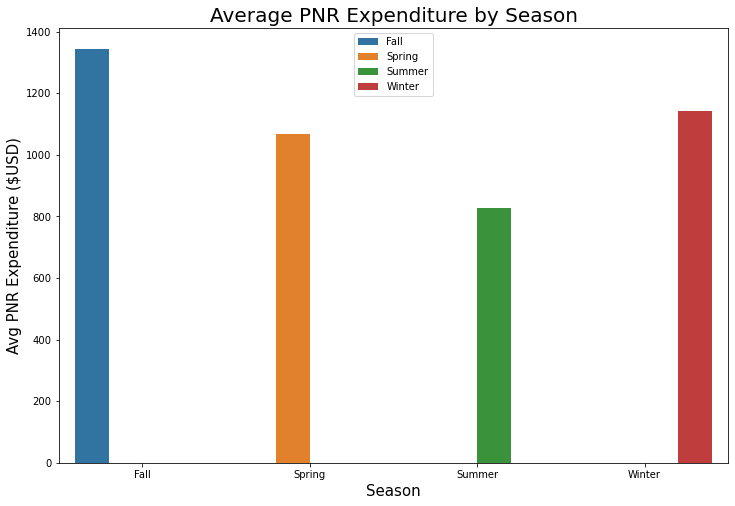

In [10]:
# make plot of avg expenditure by season

plt.figure(figsize = (12,8))
sns.barplot(x = "Season",
            y = 'Total_Amount',
            hue = "Season",
            data = df_by_season
            )
plt.ylabel("Avg PNR Expenditure ($USD)", size=15)
plt.xlabel("Season", size = 15)
plt.title("Average PNR Expenditure by Season", size=20)
plt.legend(loc='upper center')

# Show the plot
plt.show()

In [11]:
# Groupby month and year

df_by_month_year = df.groupby(["Year", "Month"]).mean()
df_by_month_year = pd.DataFrame(df_by_month_year)
df_by_month_year.head()


Match        Day  Invoice_total  Flight_total  Hotel_total  \
Year Month                                                               
2018 10       0.0  15.654321     472.739877    331.686790   104.377901   
     11       0.0  15.738095     410.231310    288.898214   164.636429   
     12       0.0  11.885714     479.716000    408.244286   146.998000   
2019 1        0.0  16.479532     443.959883    373.470117   102.807895   
     2        0.0  13.418301     443.939150    360.912876   118.622680   

            Car_total   Tax_total  Total_Amount  
Year Month                                       
2018 10      0.000000  135.883333   1044.687901  
     11      0.000000   83.442143    947.208095  
     12      0.000000   62.853714   1097.812000  
2019 1       1.172515   63.100117    984.510526  
     2       0.764706   78.519281   1002.758693

In [12]:
# add year and month back as columns to help make plot

df_by_month_year["Year"] = df_by_month_year.index.get_level_values(0)
df_by_month_year["Month"] = df_by_month_year.index.get_level_values(1)
df_by_month_year["ind"] = [i for i in range(len(df_by_month_year))]
df_by_month_year.head()

Match        Day  Invoice_total  Flight_total  Hotel_total  \
Year Month                                                               
2018 10       0.0  15.654321     472.739877    331.686790   104.377901   
     11       0.0  15.738095     410.231310    288.898214   164.636429   
     12       0.0  11.885714     479.716000    408.244286   146.998000   
2019 1        0.0  16.479532     443.959883    373.470117   102.807895   
     2        0.0  13.418301     443.939150    360.912876   118.622680   

            Car_total   Tax_total  Total_Amount  Year  Month  ind  
Year Month                                                         
2018 10      0.000000  135.883333   1044.687901  2018     10    0  
     11      0.000000   83.442143    947.208095  2018     11    1  
     12      0.000000   62.853714   1097.812000  2018     12    2  
2019 1       1.172515   63.100117    984.510526  2019      1    3  
     2       0.764706   78.519281   1002.758693  2019      2    4

In [13]:
# adding a column with the datetime for each month/year in the grouped table

df_by_month_year["year_str"] = [str(x) for x in df_by_month_year["Year"]]
df_by_month_year["month_str"] = [str(x) for x in df_by_month_year["Month"]]
df_by_month_year["date"] = [list(df_by_month_year["year_str"])[i] + "-" + list(df_by_month_year["month_str"])[i] + "-01" for i in range(len(df_by_month_year))]
df_by_month_year["date"] = pd.to_datetime(df_by_month_year["date"])
df_by_month_year

Match        Day  Invoice_total  Flight_total  Hotel_total  \
Year Month                                                                  
2018 10     0.000000  15.654321     472.739877    331.686790   104.377901   
     11     0.000000  15.738095     410.231310    288.898214   164.636429   
     12     0.000000  11.885714     479.716000    408.244286   146.998000   
2019 1      0.000000  16.479532     443.959883    373.470117   102.807895   
     2      0.000000  13.418301     443.939150    360.912876   118.622680   
     3      0.000000  15.356877    -278.151524   -240.068178    87.976283   
     4      0.000000  14.307692     -56.730769    -35.160359   108.957333   
     5      0.000000  16.204793     105.087473     46.040479    88.017081   
     6      0.000000  15.042373     213.608347    128.169131    77.721843   
     7      0.000000  14.673516     153.254224     86.059041    77.051918   
     8      0.000000  17.006394     498.491726    389.899859    71.191880   
     9      0.000000  15.674066     643.191326    536.480466   121.050133   
     10     0.000000  15.971333     622.186518    517.747888   143.045847   
     11     0.000000  14.506609     599.225799    492.396516   138.225087   
     12     0.000000  12.375636     661.205545    540.498616   114.652158   
2020 1      0.000000  17.023160     524.268758    427.171136   118.086560   
     2      0.000000  14.642730     398.770201    322.043055    88.793905   
     3      0.000000   6.069597     257.429048    205.837674    50.265440   
     4      0.000000   6.366667     282.952667    272.630000     7.107000   
     5      0.000000  14.695652     102.106522     89.602174    68.933043   
     6      0.000000  17.107143     465.285000    401.788571   115.508571   
     7      0.000000  16.961538     175.023462    159.919231   134.365000   
     8      0.000000  15.787234     673.476383    629.942766   169.211702   
     9      0.000000  15.293333     442.606933    344.605467    88.478267   
     10     0.000000  15.607843     685.929412    569.753725   117.869412   
     11     0.030303  13.454545     338.929091    275.217576   109.386970   
     12     0.000000  18.350000     734.801500    562.543500    58.657500   
2021 1      0.013333  17.226667     431.082667    337.587333    65.471067   
     2      0.033898  14.779661     408.561525    310.733559    74.493220   
     3      0.031250  13.322917     607.543021    520.318750   125.715937   
     4      0.000000  19.561983     383.187355    312.147769   141.044545   
     5      0.036842  14.557895     350.306895    284.532579   161.704737   
     6      0.065217  16.927536     425.059746    339.968080   155.614710   
     7      0.126923  16.028846     368.878731    299.632038   111.616000   
     8      0.676856  16.687773     481.921965    373.875393   125.762009   
     9      0.960145  16.752415     481.212597    373.684698   127.718140   
     10     0.915672  16.747017     670.266309    539.115354   135.209515   
     11     0.915378  13.747762     591.000317    497.734052   128.456469   
     12     0.379245  10.109434     521.572396    415.719245   130.594340   
2022 1      0.045519  17.576102     620.006856    476.033713   143.073741   
     2      0.020580  15.117867     628.264312    509.525847   147.717521   
     3      0.006140   9.413661     970.103415    798.426508   170.365012   

            Car_total   Tax_total  Total_Amount  Year  Month  ind year_str  \
Year Month                                                                   
2018 10      0.000000  135.883333   1044.687901  2018     10    0     2018   
     11      0.000000   83.442143    947.208095  2018     11    1     2018   
     12      0.000000   62.853714   1097.812000  2018     12    2     2018   
2019 1       1.172515   63.100117    984.510526  2019      1    3     2019   
     2       0.764706   78.519281   1002.758693  2019      2    4     2019   
     3       1.195316  -40.378141   -469.426245  2019      3    5     2019   
  

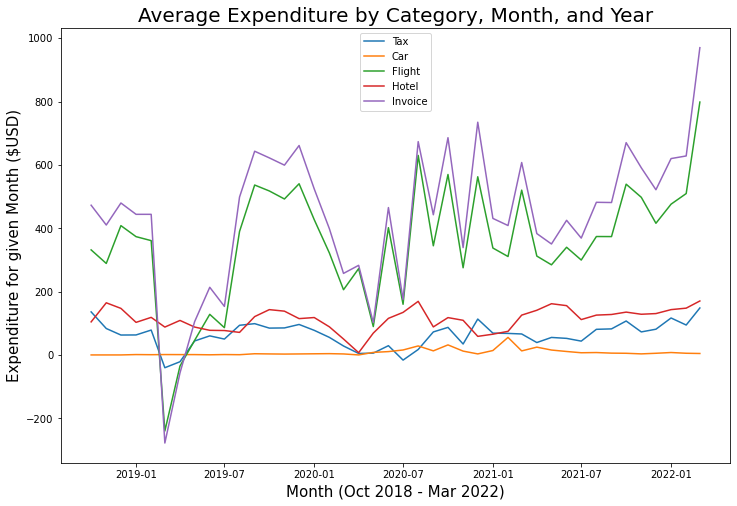

In [14]:
# make plot of expenditures by category for each month/year

plt.figure(figsize = (12,8))
sns.lineplot(data=df_by_month_year, x="date", y="Tax_total")
sns.lineplot(x=df_by_month_year["date"], y=df_by_month_year["Car_total"])
sns.lineplot(x=df_by_month_year["date"], y=df_by_month_year["Flight_total"])
sns.lineplot(x=df_by_month_year["date"], y=df_by_month_year["Hotel_total"])
sns.lineplot(x=df_by_month_year["date"], y=df_by_month_year["Invoice_total"])

plt.legend(["Tax", "Car", "Flight", "Hotel", "Invoice"], loc='upper center')
plt.ylabel("Expenditure for given Month ($USD)", size=15)
plt.xlabel("Month (Oct 2018 - Mar 2022)", size = 15)
plt.title("Average Expenditure by Category, Month, and Year", size=20)

plt.show()

In [ ]:
# clear outputs before pushing code
# can encrypt and send it through slack or data science sharepoint
# can aggregate by PNR or by each category

# Questions:
# Why are there some negative fares/expenses? How should we deal with them?

In [15]:
df

,_id,PNR,Date,Match,Invoice,Flight,Hotel,Car,Tax,EmployeeID,Year,Month,Day,Invoice_total,Flight_total,Hotel_total,Car_total,Tax_total,Total_Amount,Season
0,6238eef75962235f42d2ad0e,HKFUSA,20211231,False,"[{'Amount': 0, 'CurrencyCode': 'USD', 'Account...","[{'Fare': 0, 'CurrencyCode': 'USD', 'InvoiceNu...",[],[],"[{'Amount': -2.09, 'CurrencyCode': 'USD', 'Inv...",782753561,2021,12,31,27.00,0.00,0.00,0.0,-2.09,24.91,Winter
1,6238eef75962235f42d2ad0d,0T32H6,20211230,False,"[{'Amount': 0.64, 'CurrencyCode': 'USD', 'Acco...",[],[],[],[],482171300,2021,12,30,0.77,0.00,0.00,0.0,0.00,0.77,Winter
2,6238eef75962235f42d2ad0c,0T2J4H,20211230,False,"[{'Amount': 0.64, 'CurrencyCode': 'USD', 'Acco...",[],[],[],[],437750366,2021,12,30,0.77,0.00,0.00,0.0,0.00,0.77,Winter
3,6238eef75962235f42d2ad0b,RPHEGI,20211230,True,"[{'Amount': 549.15, 'CurrencyCode': 'USD', 'Ac...","[{'Fare': 250.69, 'CurrencyCode': 'USD', 'Invo...",[],[],"[{'Amount': 0, 'CurrencyCode': 'USD', 'Invoice...",493652216,2021,12,30,582.06,501.38,0.00,0.0,52.16,1135.60,Winter
4,6238eef75962235f42d2ad0a,GLRCIC,20211229,False,"[{'Amount': 0, 'CurrencyCode': 'USD', 'Account...",[],"[{'Amount': 460, 'CurrencyCode': 'USD', 'Hotel...",[],[],530843380,2021,12,29,8.00,0.00,460.00,0.0,0.00,468.00,Winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40264,6238eee95962235f42d20fc6,UIATXI,20220303,False,"[{'Amount': 0, 'CurrencyCode': 'USD', 'Account...",[],"[{'Amount': 359, 'CurrencyCode': 'USD', 'Hotel...",[],[],493652216,2022,3,3,8.00,0.00,359.00,0.0,0.00,367.00,Spring
40265,6238eee95962235f42d20fc5,XFHRVK,20220302,False,"[{'Amount': 285.22, 'CurrencyCode': 'USD', 'Ac...","[{'Fare': 228.94, 'CurrencyCode': 'USD', 'Invo...","[{'Amount': 225.97, 'CurrencyCode': 'USD', 'Ho...",[],"[{'Amount': 31.6, 'CurrencyCode': 'USD', 'Invo...",740854342,2022,3,2,4009.54,3263.87,919.30,0.0,668.74,8861.45,Spring
40266,6238eee95962235f42d20fc4,KUDSPS,20220224,False,"[{'Amount': 153.6, 'CurrencyCode': 'USD', 'Acc...","[{'Fare': 129.3, 'CurrencyCode': 'USD', 'Invoi...","[{'Amount': 250.17, 'CurrencyCode': 'USD', 'Ho...","[{'Amount': 67, 'CurrencyCode': 'USD', 'CarTyp...","[{'Amount': 9.7, 'CurrencyCode': 'USD', 'Invoi...",437750366,2022,2,24,239.60,194.42,504.99,134.0,29.18,1102.19,Winter
40267,6238eee95962235f42d20fc3,ZXNHKW,20220217,False,"[{'Amount': 6387.77, 'CurrencyCode': 'USD', 'A...","[{'Fare': 3136.2, 'CurrencyCode': 'USD', 'Invo...","[{'Amount': 696.04, 'CurrencyCode': 'USD', 'Ho...",[],"[{'Amount': 39.4, 'CurrencyCode': 'USD', 'Invo...",482171300,2022,2,17,6774.87,6599.00,2063.87,0.0,95.87,15533.61,Winter


In [99]:
# make function that can count the frequency of charges to each segment of a column (used to build piechart)

def frequency_of_charges(df, column):
    """
    Description:
    Takes a column from the dataframe and counts how many charges/invoices come from each segment.
    
    Input:
    column:  The column we want to count frequency of charges (str)
    df: Dataframe (table)
    
    Output:
    Dictionary containing count of charges for each segment in the given column (dictionary)
    """
    invoices = list(df[column])
    segment_count_dictionary = {}
    
    # counting frequency of charges per segment
    for i in invoices:
        for d in i:
            if d["Segment"] in segment_count_dictionary:
                segment_count_dictionary[d["Segment"]] += 1
            else:
                segment_count_dictionary[d["Segment"]] = 1
                
    # sorting the values of the dictionary
    x = segment_count_dictionary
    segment_count_dictionary = {k: v for k, v in sorted(x.items(), key=lambda item: item[1])}
    return segment_count_dictionary


invoice_segments = frequency_of_charges(df, "Invoice")             
print(invoice_segments) 

{'INTERNATIONAL AREA MGT': 24, 'IS OTHER': 606, 'CREDIT SERVICES': 707, 'CLEARANCE AND COLLATERAL MANAGEMENT': 814, 'EXECUTIVE MANAGEMENT': 1919, 'ISSUER SERVICES': 2254, 'OPS AND TECH ENTERPRISE': 2700, 'TREASURY SERVICES': 3308, 'MARKETS': 3709, 'PERSHING': 6809, 'OPERATIONS': 7862, 'WEALTH MANAGEMENT': 10291, 'TECHNOLOGY': 11166, 'ASSET SERVICING': 11907, 'CORPORATE STAFF': 12104, 'BNY MELLON INVESTMENT MGMT BUSINESS': 16352, 'N/A': 17541}


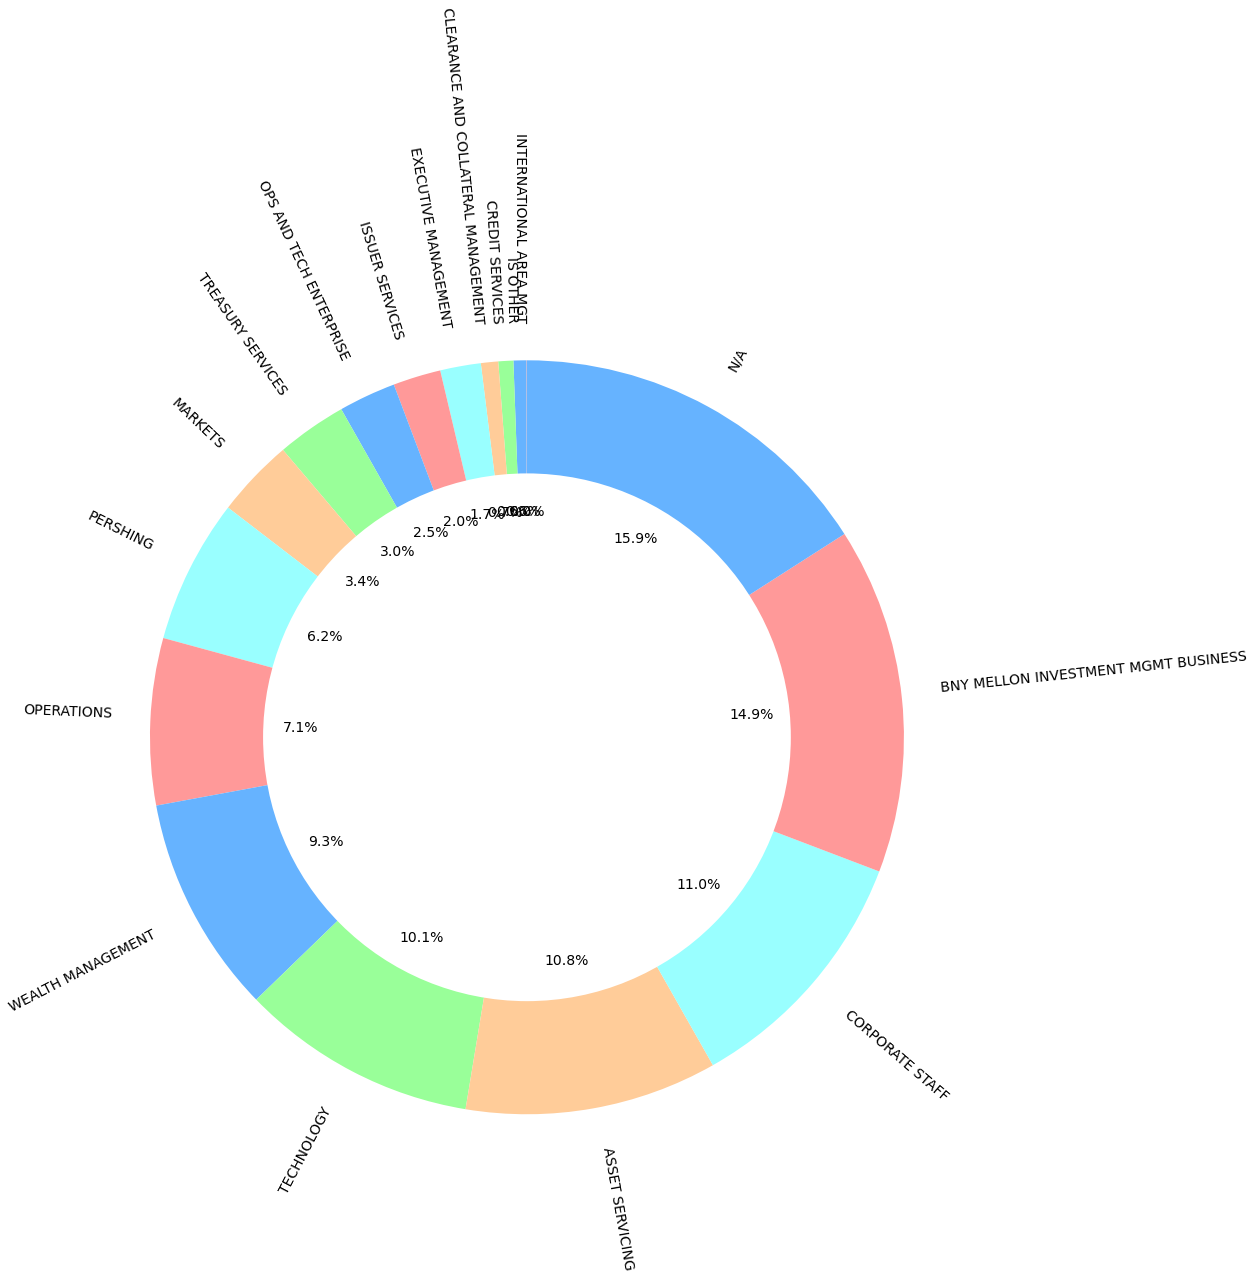

In [125]:
# Donut chart displaying counts of invoices by each segment
labels = list(invoice_segments.keys())

sizes = list(invoice_segments.values())

#colors
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99', "#99ffff"]
 
fig1, ax1 = plt.subplots()
ax1.pie(sizes, colors = colors, labels=labels, autopct='%1.1f%%', startangle=90, rotatelabels=True)
# texts = ax1.pie(sizes, colors = colors, labels=labels, autopct='%1.1f%%', startangle=90, rotatelabel=True)
# for tx in texts[1]:
#     rot = tx.get_rotation()
#     tx.set_rotation(rot+(1-rot//180))

#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# modifying myself
plt.rcParams['figure.figsize'] = (18, 18)
plt.rc('font', size=14) 

# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
# plt.title("Frequency of Invoices by Segment", size=30)

plt.show()

In [144]:
# Now lets explore the cash amount (as opposed to frequency) spent by each segment

# add segment as its own column to make it easier
df["segment"] = [df["Invoice"][i][0]["Segment"] for i in range(len(df))]

# groupby segment and aggregate as the sum
segment_df = df.groupby("segment").sum()
segment_df.reset_index(inplace=True)

# sort by "Total amount" which is total expenditures
segment_df = segment_df.sort_values(by=['Total_Amount'], ascending=False)
segment_df.reset_index(inplace=True)
segment_df

,index,segment,Match,Year,Month,Day,Invoice_total,Flight_total,Hotel_total,Car_total,Tax_total,Total_Amount
0,1,BNY MELLON INVESTMENT MGMT BUSINESS,833,12971767,43991,97414,3778124.50,3082784.54,823712.86,24492.32,574358.56,8283472.78
1,10,N/A,175,12750936,44726,94810,3371466.72,2733991.31,728863.18,19984.24,493281.70,7347587.15
2,0,ASSET SERVICING,557,9246888,31491,70035,2813701.35,2302761.50,605358.56,11556.53,408665.03,6142042.97
3,3,CORPORATE STAFF,388,8313473,27866,62237,2297491.16,1879173.36,447920.46,6987.42,347319.42,4978891.82
4,14,TECHNOLOGY,129,6668440,22572,49801,1930076.69,1487360.66,342624.14,6641.58,368566.79,4135269.86
5,11,OPERATIONS,118,5412458,18781,39573,1544517.10,1249568.70,321215.13,7066.31,230664.43,3353031.67
6,16,WEALTH MANAGEMENT,632,8555377,27970,62875,1376052.57,1138401.21,551035.51,47755.01,172708.07,3285952.37
7,13,PERSHING,321,5732354,20090,41557,1030741.12,869601.93,337989.41,16877.26,120944.85,2376154.57
8,5,EXECUTIVE MANAGEMENT,75,902970,2940,6518,922906.23,788758.02,99036.39,1065.68,106780.86,1918547.18
9,9,MARKETS,177,2789513,9477,21183,822982.10,677117.93,162279.35,3283.68,123964.24,1789627.30


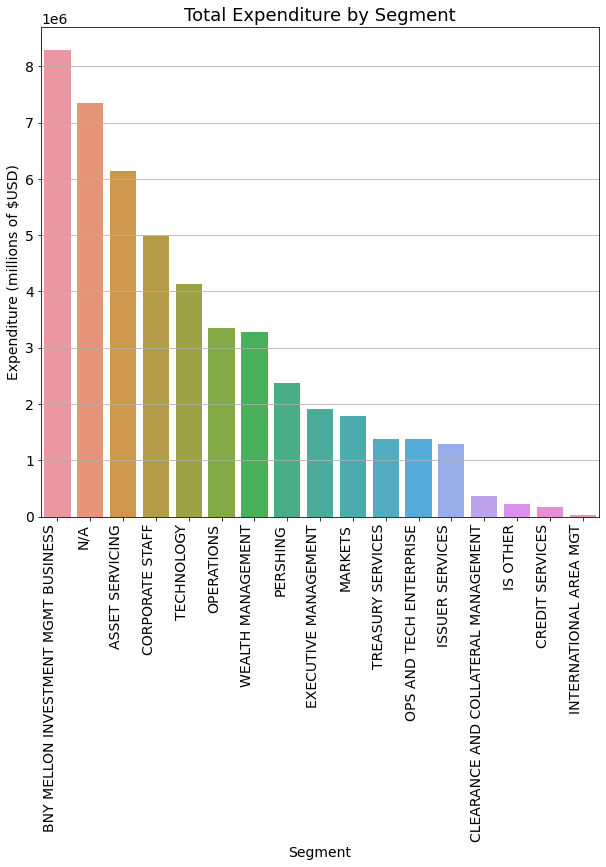

In [146]:
# make plot for total expenditures by each segment

y = segment_df["Total_Amount"]
x = segment_df["segment"]

g = sns.barplot( x=x, y=y, data=segment_df)
g.figure.autofmt_xdate()
plt.xlabel("Segment", fontsize=14)
plt.ylabel("Expenditure (millions of $USD)", fontsize=14)
plt.title("Total Expenditure by Segment", fontsize=18)
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
axes = plt.gca()
axes.yaxis.grid()
plt.rcParams['figure.figsize'] = (10, 10)
plt.show(g)

In [147]:
# Now groupby segment but instead aggregate by the mean to see average PNR expense by segment
segment_df = df.groupby("segment").mean()
segment_df.reset_index(inplace=True)

# sort by "Total amount" which is actually average amount now because we aggregated on the mean
segment_df = segment_df.sort_values(by=['Total_Amount'], ascending=False)
segment_df.reset_index(inplace=True)
segment_df

,index,segment,Match,Year,Month,Day,Invoice_total,Flight_total,Hotel_total,Car_total,Tax_total,Total_Amount
0,5,EXECUTIVE MANAGEMENT,0.167785,2020.067114,6.577181,14.581655,2064.667181,1764.559329,221.557919,2.384072,238.883356,4292.051857
1,6,INTERNATIONAL AREA MGT,0.133333,2020.266667,4.800000,15.333333,892.549333,805.612667,99.413333,2.466667,81.279333,1881.321333
2,12,OPS AND TECH ENTERPRISE,0.029736,2019.442731,7.176211,15.223568,702.303700,559.707423,135.958194,1.503932,120.066608,1519.539857
3,8,ISSUER SERVICES,0.097950,2019.782460,6.910023,14.432802,674.001207,567.811298,132.935308,4.792870,84.941219,1464.481902
4,0,ASSET SERVICING,0.121669,2019.853211,6.878768,15.298165,614.613663,503.006007,132.232101,2.524362,89.267154,1341.643287
5,9,MARKETS,0.128168,2019.922520,6.862419,15.338885,595.932006,490.309870,117.508581,2.377755,89.764113,1295.892324
6,1,BNY MELLON INVESTMENT MGMT BUSINESS,0.129710,2019.895204,6.850047,15.168795,588.309639,480.034964,128.264226,3.813815,89.436088,1289.858732
7,14,TECHNOLOGY,0.039067,2019.515445,6.835857,15.082071,584.517471,450.442356,103.762611,2.011381,111.619258,1252.353077
8,11,OPERATIONS,0.044030,2019.573881,7.007836,14.766045,576.312351,466.256978,119.856392,2.636683,86.068817,1251.131220
9,3,CORPORATE STAFF,0.094266,2019.794218,6.770165,15.120748,558.185413,456.553294,108.824213,1.697624,84.382755,1209.643299


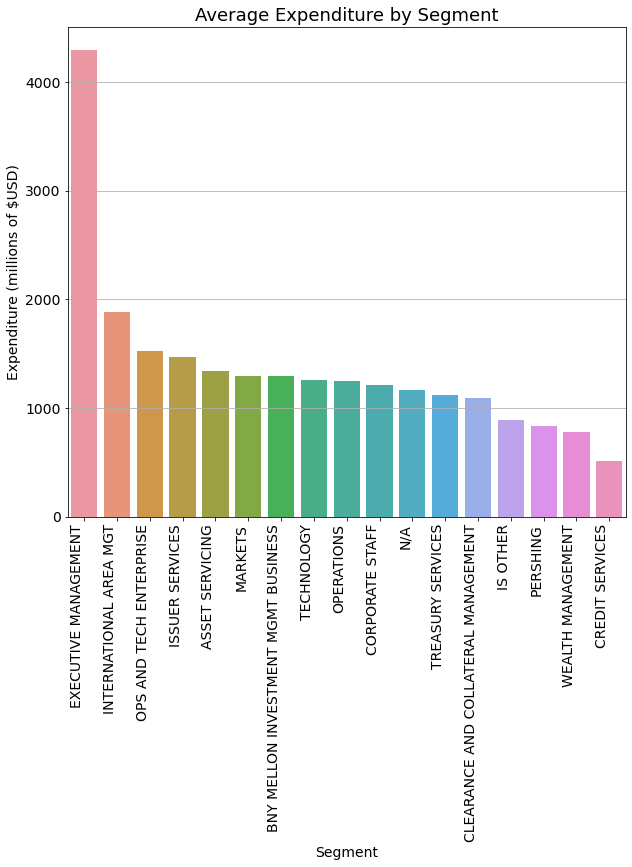

In [149]:
y = segment_df["Total_Amount"]
x = segment_df["segment"]

g = sns.barplot( x=x, y=y, data=segment_df)
g.figure.autofmt_xdate()
plt.xlabel("Segment", fontsize=14)
plt.ylabel("Expenditure (millions of $USD)", fontsize=14)
plt.title("Average Expenditure by Segment", fontsize=18)
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
axes = plt.gca()
axes.yaxis.grid()
plt.rcParams['figure.figsize'] = (10, 10)
plt.show(g)